In [ ]:
import pandas as pd
import numpy as np
import re

In [ ]:
df = pd.read_csv('simpsons_dataset.csv')
df.shape

(158314, 2)

In [ ]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [ ]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()


raw_character_text    0
spoken_words          0
dtype: int64

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])


In [ ]:
from time import time
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000,n_process=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))


Time to clean up everything: 4.66 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(73568, 1)

In [ ]:
from gensim.models.phrases import Phrases, Phraser


In [ ]:
sent = [row.split() for row in df_clean['clean']]

In [ ]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [ ]:
bigram = Phraser(phrases)

In [ ]:
sentences = bigram[sent]


In [ ]:
from collections import defaultdict
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

27610

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]


['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'look', 'right', 'want']

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
cores = multiprocessing.cpu_count()

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.93 mins


In [ ]:
w2v_model.init_sims(replace=True)


<ipython-input-36-c7757d71a30b>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [ ]:
w2v_model.wv.most_similar(positive=["homer"])

[('gee', 0.829410195350647),
 ('convince', 0.8282300233840942),
 ('fellas', 0.8178064823150635),
 ('darling', 0.8150588274002075),
 ('marge', 0.8103805780410767),
 ('boyfriend', 0.8074268102645874),
 ('bongo', 0.8006280660629272),
 ('grownup', 0.796782910823822),
 ('attractive', 0.7893219590187073),
 ('snuggle', 0.787124752998352)]

In [ ]:
w2v_model.wv.most_similar(positive=["homer_simpson"])


[('progress', 0.7871962785720825),
 ('easily', 0.7834977507591248),
 ('current', 0.7788358926773071),
 ('crew', 0.7786836624145508),
 ('surrender', 0.767555832862854),
 ('governor', 0.7667161226272583),
 ('cheech', 0.765526533126831),
 ('waylon', 0.7633056640625),
 ('section', 0.7626955509185791),
 ('unit', 0.7618179321289062)]

In [ ]:
w2v_model.wv.most_similar(positive=["marge"])


[('darling', 0.831108570098877),
 ('homer', 0.8103805780410767),
 ('rude', 0.794854998588562),
 ('homie', 0.7914109230041504),
 ('affair', 0.7907084822654724),
 ('sorry', 0.7892588376998901),
 ('nervous', 0.7868970632553101),
 ('surprised', 0.7865517139434814),
 ('ashamed', 0.7836024761199951),
 ('attractive', 0.7812210321426392)]

In [ ]:
w2v_model.wv.most_similar(positive=["bart"])


[('lisa', 0.864819347858429),
 ('dr_hibbert', 0.8259303569793701),
 ('fault', 0.803900420665741),
 ('selfish', 0.8030387163162231),
 ('upset', 0.8026641607284546),
 ('homework', 0.8010514974594116),
 ('mom_dad', 0.7977606058120728),
 ('substitute', 0.7969027757644653),
 ('babysitter', 0.7963118553161621),
 ('quietly', 0.7961093187332153)]

In [ ]:
w2v_model.wv.similarity('maggie', 'baby')

0.67246044

In [ ]:
matrix= []
entries = ['maggie','baby','bart','nelson', 'tavern']
for i in entries:
  l1=[]
  for j in entries:
      l1.append(w2v_model.wv.similarity(i,j))
  matrix.append(l1)

In [ ]:
matrix

[[1.0, 0.67246044, 0.70239043, 0.58085304, 0.30040464],
 [0.67246044, 1.0, 0.49093485, 0.5241181, 0.29473165],
 [0.70239043, 0.49093485, 1.0, 0.6997478, 0.31886333],
 [0.58085304, 0.5241181, 0.6997478, 0.99999994, 0.29000902],
 [0.30040464, 0.29473165, 0.31886333, 0.29000902, 0.99999994]]

In [ ]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [ ]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)


[('story', 0.6982041001319885),
 ('someday', 0.694936215877533),
 ('generation', 0.6920658349990845)]

LABSHEET TASK

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from collections import defaultdict

In [ ]:
class Settings():
  def __init__(self):
    # Hyper Parameter
    self.m = 3
    self.d = 10
    self.a = 0.01
    self.epoch = 100
    self.xmax = 1
    self.f_a = 0.75

In [ ]:
class Data():

  def __init__(self, settings):
    self.m = settings.m
    self.make_corpus()
    self.co_occurrence_matrix()

  def make_corpus(self):
    text = "i love doing this project it is the thing which i enjoy the most"
    corpus = text.split('.') # TODO
    self.corpus = [corpus[i].split(' ') for i in range(len(corpus))]

  def preparation(self):
    """ Making the frequency matrix"""
    self.word_freq = defaultdict(int)
    # TODO: Implement the logic for word_freq
    for sentence in self.corpus:
        for word in sentence:
          self.word_freq[word] += 1
    # self.words decide the index of all the words
    self.words = list(self.word_freq.keys())
    self.T = len(self.words)
  # word_index will give index for a given word and vice versa for index_word

    self.word_index = {word: idx for idx, word in enumerate(self.words)} # HINT: Use list comprehension
    self.index_word = {idx: word for idx, word in enumerate(self.words)}

  def co_occurrence_matrix(self):
    self.preparation()
    self.X = np.zeros((self.T, self.T))
    for sentence in self.corpus:
      sen_len = len(sentence)
      for i, c_word in enumerate(sentence):
        # target is the center word index
        # context is the context word index
        target = self.word_index[c_word]
        for j in range(max(0, i - self.m), min(sen_len, i + self.m + 1)):
          if j != i and 0 <= j and j < sen_len:
            context_word = sentence[j]
            context = self.word_index[context_word]

            self.X[target, context] += 1

In [ ]:
class Model():

  def __init__(self, data, settings):
    self.settings = settings
    self.data = data
    self.X = self.data.X
    self.fun = np.vectorize(self.f)
    self.plot_initialise()
    # TODO: Appropriate additions, if any
    self.U =None
    self.V =None
    self.i1_list =[]
    self.J_list =[]

  def train(self):
    self.prepare()
    i_list = []
    # Iterating through the entire dataset epoch number of times
    # TODO: Replace ... with the epoch taken from settings
    for i in range(0,self.settings.epoch):
      delta = self.fun(self.X) * (self.U @ self.V -np.log(self.X+1))
      U_grad = delta @ self.V.T
      V_grad = self.U.T @ delta

      U_grad[:, self.settings.d+1] = 0
      V_grad[self.settings.d+1, :] = 0
      # Updating U and V

      self.U -= self.settings.a * U_grad
      self.V -= self.settings.a * V_grad
      i_list.append(i)
      # Plotting Loss
      self.update_loss()
    self.plot(i_list)

  def prepare(self):
    self.U = np.random.uniform(-1, 1, (self.data.T, self.settings.d+ 2))
    self.V = np.random.uniform(-1, 1, (self.settings.d + 2,self.data.T))

    for i in range(0, self.data.T):
      self.U[self.settings.d + 1, i] = 1
      self.V[i, self.settings.d + 1] = 1

  def f(self, x):
    if x > self.settings.xmax:
      return 1
    else:
      y = (x/self.settings.xmax)**self.settings.f_a
      return y
  def update_loss(self):
    J = self.fun(self.X) * ((self.U @ self.V - np.log(self.X+1))**2)
    self.J = J.sum() / 2
    self.J_list.append(self.J)

  def plot(self, i): # TODO Update the function to get one graph
    # s - Marker size
    plt.scatter(i, self.J_list, color = 'red', s = 3)
    plt.show(block = False)
    plt.pause(0.001)

  def plot_initialise(self):
    style.use('dark_background')
    plt.figure()
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss')

  def predict(self, word):
    index = self.data.word_index.get(word, -1)
    if index != -1:
     w = self.U[index, :] + self.V[:, index]
     return w[1:-1] / 2
    else:
      return None  # Return None for words not found in the corpus

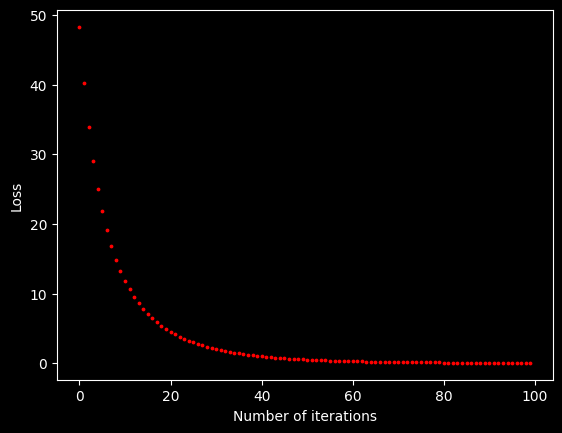

In [ ]:
settings = Settings()
data = Data(settings)
model = Model(data, settings)
model.train()

In [ ]:
class Settings2():
  def __init__(self):
    # Hyper Parameter
    self.m = 1
    self.d = 10
    self.a = 0.01
    self.epoch = 50
    self.xmax = 1
    self.f_a = 0.75

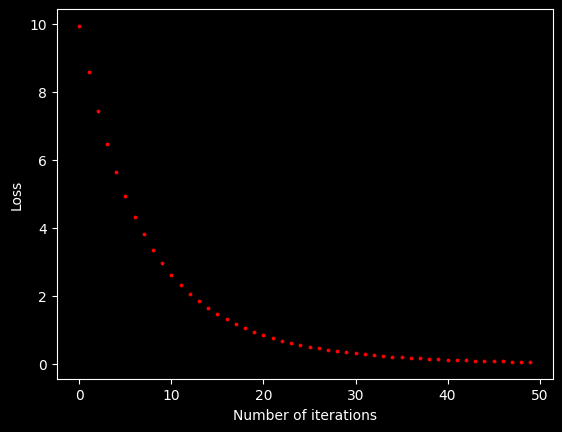

In [ ]:
settings = Settings2()
data = Data(settings)
model = Model(data, settings)
model.train()

In [ ]:
class Settings3():
  def __init__(self):
    # Hyper Parameter
    self.m = 3
    self.d = 10
    self.a = 0.001
    self.epoch = 100
    self.xmax = 1
    self.f_a = 0.75

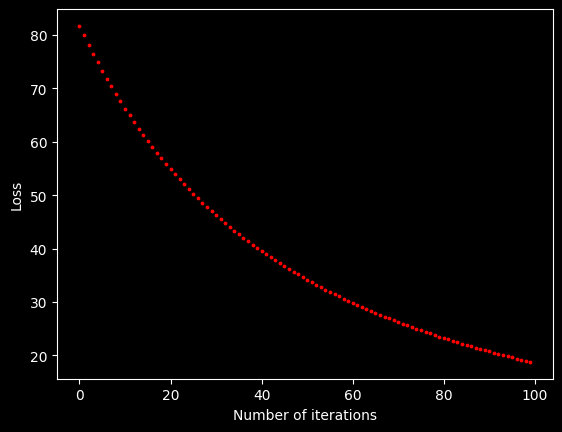

In [ ]:
settings = Settings3()
data = Data(settings)
model = Model(data, settings)
model.train()

In [ ]:
class Settings4():
  def __init__(self):
    # Hyper Parameter
    self.m = 3
    self.d = 10
    self.a = 0.001
    self.epoch = 100
    self.xmax = 3
    self.f_a = 0.75

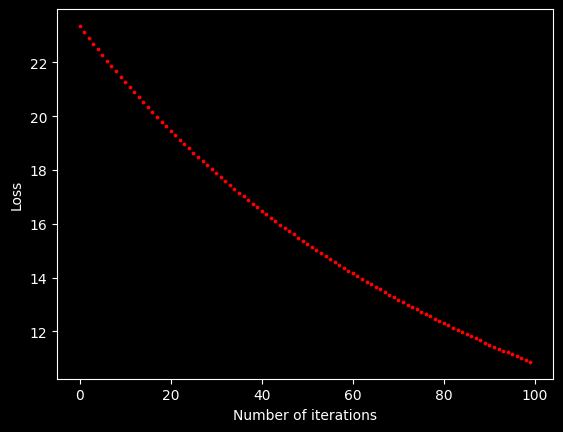

In [ ]:
settings = Settings4()
data = Data(settings)
model = Model(data, settings)
model.train()

In [ ]:
class Settings5():
  def __init__(self):
    # Hyper Parameter
    self.m = 5
    self.d = 10
    self.a = 0.01
    self.epoch = 100
    self.xmax = 5
    self.f_a = 0.75

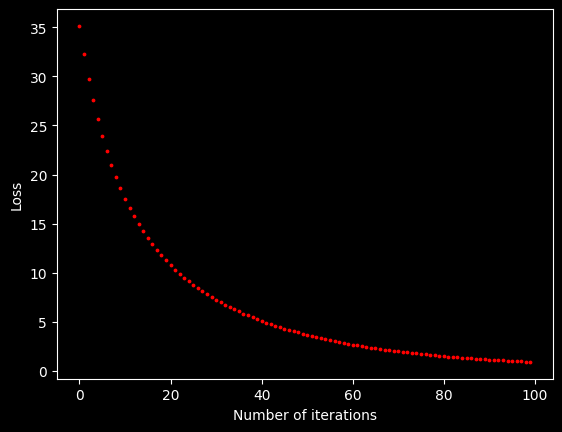

In [ ]:
settings = Settings5()
data = Data(settings)
model = Model(data, settings)
model.train()

In [ ]:
word = input('Enter the word whose vector you want to see.\n')
print(model.predict(word))

Enter the word whose vector you want to see.
this
[ 0.59289125  0.67876135  0.03108412  0.55929668  0.30353098  0.29520583
  0.25037668  0.74823229 -0.25128678 -0.77056857]
